In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import ProgBar
pd.set_option('display.max_columns', None)

# Declarando funções utilizadas

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import ProgBar
from functools import reduce


class snt_reader:
    def __init__(self, file) -> None:
        bar = ProgBar(2, "Lendo tabelas da planilha...")

        # Lê tabela de incrição
        self.inscricao = pd.read_excel(
            file,
            sheet_name=0,
            header=4,
        )

        bar.update()

        # Lê tabela de obitos
        self.obitos = pd.read_excel(
            file,
            sheet_name=4,
            header=5,
        )

        bar.update()

        # Lê tabela de transplantes
        self.tranplantes = pd.read_excel(
            file,
            sheet_name=2,
            header=4,
        )

        bar.update()

    def format_kp_obito(self, verbose=True):
        # Faz o join entre tabelas
        df_result = self.inscricao.set_index("ID").join(
            self.obitos.set_index("ID"), on=["ID"], lsuffix="_insc", rsuffix="_obt"
        )

        df_result = df_result.dropna(subset=["Data da Inscrição"])

        self.n_amostras = len(df_result)

        # Retira pacientes que não vieram a óbito
        df_result = df_result.dropna(subset=["Data do Óbito"])

        return df_result

    def format_kp_fila(self, verbose=True):
        # Gera lista de
        dfs = [self.inscricao, self.obitos, self.tranplantes]

        final_df = reduce(
            lambda left, right: pd.merge(left, right, on=["ID"], how="outer"), dfs
        )

        # retirando colunas duplicadas

        filtered_df = final_df[
            [
                "ID",
                "Data da Inscrição_x",
                "UF origem",
                "Data do Óbito",
                "Enxerto_x",
                "UF_x",
                "Região_x",
                "Data do Transplante",
                "Tipo de Doador",
                "UF de Origem",
                "Data de Nascimento_x",
                "Sexo_x",
                "Grupo Sanguíneo_x",
                "Cor_x",
            ]
        ]

        # renomeando colunas

        filtered_df = filtered_df.rename(
            columns={
                "Data da Inscrição_x": "data_da_inscricao",
                "UF_x": "uf",
                "Data do Óbito": "data_do_obito",
                "Enxerto_x": "enxerto",
                "Região_x": "regiao",
                "Data do Transplante": "data_do_transplante",
                "Tipo de Doador": "tipo_do_doador",
                "UF de Origem": "uf_de_origem",
                "Data de Nascimento_x": "data_de_nascimento",
                "Sexo_x": "sexo",
                "Grupo Sanguíneo_x": "grupo_sanguineo",
                "Cor_x": "cor",
            }
        )

        # retirando data de inscrição null

        filtered_df = filtered_df.dropna(subset=["data_da_inscricao"])

        # retirando pacientes ainda em fila

        filtered_df = filtered_df.dropna(
            subset=["data_do_obito", "data_do_transplante"], how="all"
        )

    def kaplan_meier(self, tipo, verbose=True, plt_show=True, plt_save=True):
        if tipo == "obito":
            df = self.format_kp_obito()

            # Calcula entre inscrição e óbito
            delta_t = (
                (df["Data do Óbito"].values - df["Data da Inscrição"].values)
                / np.timedelta64(1, "D")
                / 30
            )

            # Retira delta_t negativo
            delta_t_negativo = delta_t[delta_t < 0]
            delta_t_positivo = delta_t[delta_t >= 0]

            if verbose:
                print("amostras negativas: ", len(delta_t_negativo))
                print("amostras positivas: ", len(delta_t_positivo))

            # Agrupa tempos iguais para calculo de
            # probabilidade
            unique_delta, count = np.unique(delta_t_positivo, return_counts=True)

            # Calcula probabilidades
            percentage = []
            acumulada = 100

            for n_vezes in count:
                acumulada -= (n_vezes / self.n_amostras) * 100
                percentage.append(acumulada)

            # Criando figura
            fig = plt.figure(figsize=[16, 9])
            fig.suptitle("Tempo até óbito em fila", fontsize=16)

            # Plotando 2D

            ax = fig.add_subplot(1, 1, 1)

            ax.set_ylabel("Número de pacientes (%)", fontsize=16)
            ax.set_xlabel("Meses", fontsize=16)

            ax.plot(unique_delta, percentage, "r", linewidth=2)

            ax.grid()

            if plt_show:
                plt.show()

            if plt_show:
                plt.savefig("figures/kpm_obito.png")

        elif tipo == "fila":
            pass

# Iniciando objeto

In [10]:
arquivo = "../bases_de_dados/Base de Dados_Doação e Transplantes_2015-2023.xlsx"

reader = snt_reader(arquivo)

Lendo tabelas da planilha...
[                                                  ] 0.00% - 0 of 2

KeyboardInterrupt: 

# Tempo até óbito em fila

amostras negativas:  28
amostras positivas:  16440


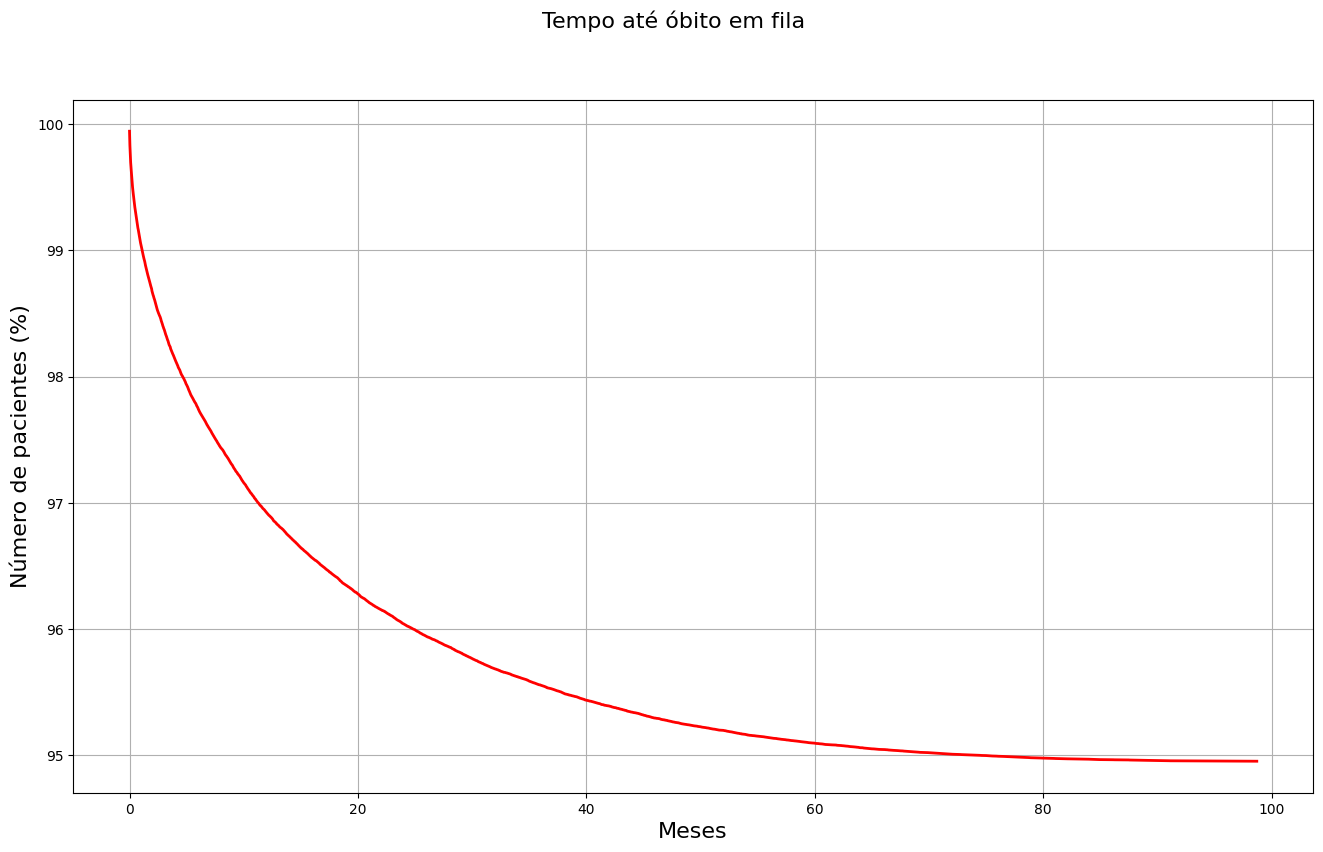

<Figure size 640x480 with 0 Axes>

In [7]:
reader.kaplan_meier('obito')

# Antigo

## tempo até o óbito em fila

In [2]:
arquivo = "../bases_de_dados/Base de Dados_Doação e Transplantes_2015-2023.xlsx"


In [3]:
# Reading spread-sheet

header_row = 4

df_inscricao = pd.read_excel(
    arquivo,
    sheet_name=0,
    header=header_row,
)

df_inscricao.head()

n_amostras = len(df_inscricao)

In [4]:
# Reading spread-sheet

header_row = 5

df_obitos = pd.read_excel(
    arquivo,
    sheet_name=4,
    header=header_row,
)
df_obitos.head()

,UF,Região,ID,Data de Nascimento,Sexo,Grupo Sanguíneo,Cor,Ano,Mês,Data do Óbito,Enxerto,Equipe,Estabelecimento,Cidade Estabelecimento,Evento
0,SP,Sudeste,154965SP,14137,F,O,Branca,2015,Janeiro,2015-01-01,RI,H. São Paulo - EPM - Medina (Rim),Hospital São Paulo da Escola Paulista de Medicina,São Paulo,Óbito Pré Transplantes
1,SP,Sudeste,171096SP,23173,F,O,Branca,2015,Janeiro,2015-01-01,RI,HCFMUSP - Rim,Hospital das Clínicas de São Paulo,São Paulo,Óbito Pré Transplantes
2,SP,Sudeste,185118SP,36270,F,B,Negra,2015,Janeiro,2015-01-01,FI,Sírio Libanês - Eduardo Antunes Fonseca,Hospital Sírio Libanês,São Paulo,Óbito Pré Transplantes
3,SP,Sudeste,179520SP,33331,M,A,Branca,2015,Janeiro,2015-01-02,FI,Hospital E.J.Zerbini - Adriano Miziara Gonzalez,Hospital Dr. Euryclides de Jesus Zerbini - Bri...,São Paulo,Óbito Pré Transplantes
4,SP,Sudeste,184177SP,20725,M,O,Branca,2015,Janeiro,2015-01-02,CO,HC - Coração adulto,Hospital das Clínicas de São Paulo,São Paulo,Óbito Pré Transplantes


In [10]:
df_result=df_inscricao.set_index('ID').join(df_obitos.set_index('ID'), on=['ID'], lsuffix="_insc", rsuffix="_obt")
df_result.head()

,UF_insc,Região_insc,Ano_insc,Mês_insc,Data da Inscrição,Enxerto_insc,Data de Nascimento_insc,Sexo_insc,Grupo Sanguíneo_insc,Cor_insc,UF origem,Equipe_insc,Estabelecimento_insc,Cidade Estabelecimento_insc,UF_obt,Região_obt,Data de Nascimento_obt,Sexo_obt,Grupo Sanguíneo_obt,Cor_obt,Ano_obt,Mês_obt,Data do Óbito,Enxerto_obt,Equipe_obt,Estabelecimento_obt,Cidade Estabelecimento_obt,Evento
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
188975SP,SP,Sudeste,2015,Janeiro,2015-01-01,CO,1967-09-06,M,O,Negra,SP,Sírio Libanês - Silvia Moreira Ayub Ferreira,Hospital Sírio Libanês,São Paulo,SP,Sudeste,24721.0,M,O,Negra,2015.0,Março,2015-03-13,CO,Sírio Libanês - Silvia Moreira Ayub Ferreira,Hospital Sírio Libanês,São Paulo,Óbito Pré Transplantes
124895PE,PE,Nordeste,2015,Janeiro,2015-01-02,FI,1954-04-16,M,O,Parda,PE,PE - IMIP - Cláudio Moura Lacerda de Lima,IMIP,RECIFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
124877PB,PB,Nordeste,2015,Janeiro,2015-01-02,RI,1974-09-25,M,O,Parda,PB,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
124880PB,PB,Nordeste,2015,Janeiro,2015-01-02,RI,1965-11-27,M,A,Parda,PB,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
124872PB,PB,Nordeste,2015,Janeiro,2015-01-02,RI,1962-12-16,M,O,Parda,PB,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [11]:
df_result_pre_pro = df_result.dropna(subset=['Data do Óbito'])

In [12]:
delta_t = (df_result_pre_pro["Data do Óbito"].values - df_result_pre_pro["Data da Inscrição"].values)/np.timedelta64(1, 'D')/30

In [13]:
delta_t_negativo = delta_t[delta_t<0]
delta_t_positivo = delta_t[delta_t>=0]

print("amostras negativas: ", len(delta_t_negativo))
print("amostras positivas: ", len(delta_t_positivo))

amostras negativas:  28
amostras positivas:  16440


In [14]:
unique_delta, count = np.unique(delta_t_positivo, return_counts=True)

percentage = []
acumulada = 100

for delta, n_vezes in zip(unique_delta, count):
    acumulada -= (n_vezes/n_amostras)*100
    percentage.append(acumulada)

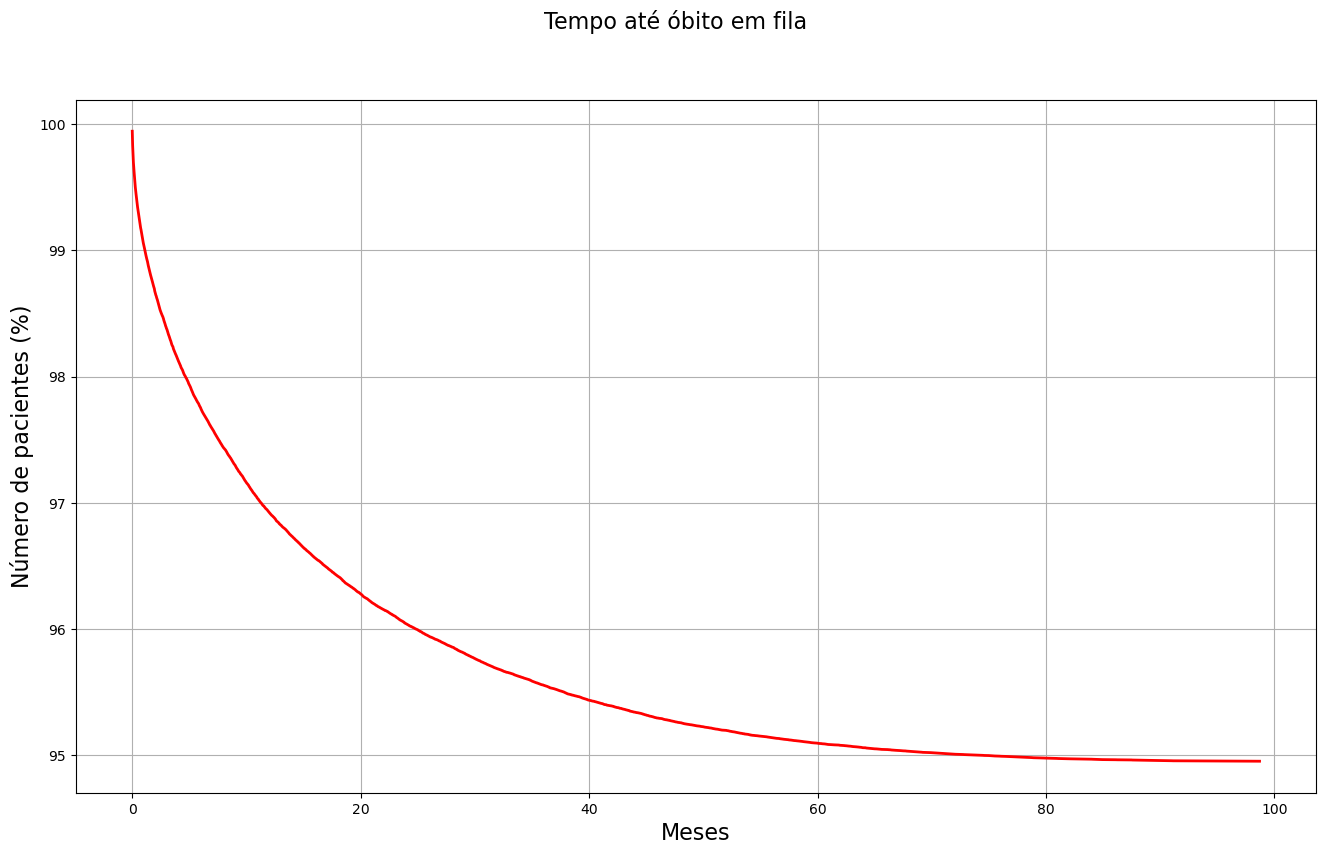

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 9])
fig.suptitle('Tempo até óbito em fila', fontsize=16)

# Plotando 2D

ax = fig.add_subplot(1, 1,1)

ax.set_ylabel('Número de pacientes (%)', fontsize=16)
ax.set_xlabel('Meses', fontsize=16)

ax.plot(unique_delta, percentage, 'r', linewidth=2)

ax.grid()

plt.show()

## Tempo até o óbito em fila

## Tempo em fila

In [5]:
# Reading spread-sheet

header_row = 4

df_tranplantes = pd.read_excel(
    arquivo,
    sheet_name=2,
    header=header_row,
)
df_tranplantes.head()

,Ano do Transplante,Mês do Transplante,Enxerto,UF,Região,Data da Inscrição,Data do Transplante,Tipo de Doador,UF de Origem,ID,Data de Nascimento,Sexo,Grupo Sanguíneo,Cor,Equipe,Estabelecimento,Cidade Estabelecimento
0,2015,Janeiro,FI,CE,Nordeste,2014-12-04,2015-01-01,Doador Falecido,CE,123647CE,1983-02-06,F,A,Parda,CE - HUWC - José Huygens Parente Garcia,HOSPITAL UNIVERSITARIO WALTER CANTIDIO - HUWC,FORTALEZA
1,2015,Janeiro,FI,PE,Nordeste,2014-12-30,2015-01-01,Doador Falecido,PE,124865PE,1954-01-14,M,O,Parda,PE - HUOC - Cláudio Moura Lacerda,HOSPITAL UNIVERSITÁRIO OSWALDO CRUZ,RECIFE
2,2015,Janeiro,RI,PE,Nordeste,2014-09-26,2015-01-01,Doador Falecido,PE,118654PE,1999-05-18,F,A,Parda,PE - IMIP - Luis Gonzaga de Negreiros Filho,IMIP,RECIFE
3,2015,Janeiro,RI,RS,Sul,2013-05-02,2015-01-01,Doador Falecido,RS,85775RS,1949-03-01,F,B,Branca,RS - ISCMPA - Valter Duro Garcia,IRMANDADE SANTA CASA DE MISERICÓRDIA DE PORTO ...,PORTO ALEGRE
4,2015,Janeiro,RI,RS,Sul,2013-11-22,2015-01-01,Doador Falecido,RS,99196RS,1950-09-29,M,B,Branca,RS - AHCI - Maria Leocádia Amaral Padilha,ASSOCIAÇÃO HOSPITAL DE CARIDADE DE IJUÍ,IJUI


In [6]:
dfs = [df_inscricao,df_obitos,df_tranplantes]

In [7]:
from functools import reduce

final_df = reduce(lambda  left,right: pd.merge(left,right,on=['ID'],
                                            how='outer'), dfs)


In [8]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344410 entries, 0 to 344409
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   UF_x                      325667 non-null  object        
 1   Região_x                  325667 non-null  object        
 2   ID                        344410 non-null  object        
 3   Ano_x                     325667 non-null  float64       
 4   Mês_x                     325667 non-null  object        
 5   Data da Inscrição_x       325667 non-null  datetime64[ns]
 6   Enxerto_x                 325667 non-null  object        
 7   Data de Nascimento_x      325667 non-null  datetime64[ns]
 8   Sexo_x                    325667 non-null  object        
 9   Grupo Sanguíneo_x         145159 non-null  object        
 10  Cor_x                     325667 non-null  object        
 11  UF origem                 325667 non-null  object        
 12  Eq

In [142]:
final_df.head()

,UF_x,Região_x,ID,Ano_x,Mês_x,Data da Inscrição_x,Enxerto_x,Data de Nascimento_x,Sexo_x,Grupo Sanguíneo_x,Cor_x,UF origem,Equipe_x,Estabelecimento_x,Cidade Estabelecimento_x,UF_y,Região_y,Data de Nascimento_y,Sexo_y,Grupo Sanguíneo_y,Cor_y,Ano_y,Mês_y,Data do Óbito,Enxerto_y,Equipe_y,Estabelecimento_y,Cidade Estabelecimento_y,Evento,Ano do Transplante,Mês do Transplante,Enxerto,UF,Região,Data da Inscrição_y,Data do Transplante,Tipo de Doador,UF de Origem,Data de Nascimento,Sexo,Grupo Sanguíneo,Cor,Equipe,Estabelecimento,Cidade Estabelecimento
0,SP,Sudeste,188975SP,2015.0,Janeiro,2015-01-01,CO,1967-09-06,M,O,Negra,SP,Sírio Libanês - Silvia Moreira Ayub Ferreira,Hospital Sírio Libanês,São Paulo,SP,Sudeste,24721.0,M,O,Negra,2015.0,Março,2015-03-13,CO,Sírio Libanês - Silvia Moreira Ayub Ferreira,Hospital Sírio Libanês,São Paulo,Óbito Pré Transplantes,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,PE,Nordeste,124895PE,2015.0,Janeiro,2015-01-02,FI,1954-04-16,M,O,Parda,PE,PE - IMIP - Cláudio Moura Lacerda de Lima,IMIP,RECIFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,PB,Nordeste,124877PB,2015.0,Janeiro,2015-01-02,RI,1974-09-25,M,O,Parda,PB,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2017.0,Janeiro,RI,PB,Nordeste,2015-01-02,2017-01-29,Doador Falecido,PB,1974-09-25,M,O,Parda,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE
3,PB,Nordeste,124880PB,2015.0,Janeiro,2015-01-02,RI,1965-11-27,M,A,Parda,PB,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2016.0,Dezembro,RI,PB,Nordeste,2015-01-02,2016-12-09,Doador Falecido,PB,1965-11-27,M,A,Parda,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE
4,PB,Nordeste,124872PB,2015.0,Janeiro,2015-01-02,RI,1962-12-16,M,O,Parda,PB,PB - HAT - Amanda Maíra Damasceno Silva,HOSPITAL ANTONIO TARGINO,CAMPINA GRANDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
final_df.columns

Index(['UF_x', 'Região_x', 'ID', 'Ano_x', 'Mês_x', 'Data da Inscrição_x',
       'Enxerto_x', 'Data de Nascimento_x', 'Sexo_x', 'Grupo Sanguíneo_x',
       'Cor_x', 'UF origem', 'Equipe_x', ' Estabelecimento_x',
       'Cidade Estabelecimento_x', 'UF_y', 'Região_y', 'Data de Nascimento_y',
       'Sexo_y', 'Grupo Sanguíneo_y', 'Cor_y', 'Ano_y', 'Mês_y',
       'Data do Óbito', 'Enxerto_y', 'Equipe_y', ' Estabelecimento_y',
       'Cidade Estabelecimento_y', 'Evento', ' Ano do Transplante',
       ' Mês do Transplante', 'Enxerto', 'UF', 'Região', 'Data da Inscrição_y',
       'Data do Transplante', 'Tipo de Doador', 'UF de Origem',
       'Data de Nascimento', 'Sexo', 'Grupo Sanguíneo', 'Cor', 'Equipe',
       'Estabelecimento', 'Cidade Estabelecimento'],
      dtype='object')

In [161]:
# retirando colunas duplicadas

filtered_df = final_df[
       [ "ID",
        "Data da Inscrição_x",
        "Data do Óbito",
        "Enxerto_x",
        "UF_x",
        "Região_x",
        "Data do Transplante",
        "Tipo de Doador",
        "UF de Origem",
        "Data de Nascimento_x",
        "Sexo_x",
        "Grupo Sanguíneo_x",
        "Cor_x",]
    ]

In [162]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344410 entries, 0 to 344409
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    344410 non-null  object        
 1   Data da Inscrição_x   325667 non-null  datetime64[ns]
 2   Data do Óbito         20225 non-null   datetime64[ns]
 3   Enxerto_x             325667 non-null  object        
 4   UF_x                  325667 non-null  object        
 5   Região_x              325667 non-null  object        
 6   Data do Transplante   185772 non-null  datetime64[ns]
 7   Tipo de Doador        185772 non-null  object        
 8   UF de Origem          185772 non-null  object        
 9   Data de Nascimento_x  325667 non-null  datetime64[ns]
 10  Sexo_x                325667 non-null  object        
 11  Grupo Sanguíneo_x     145159 non-null  object        
 12  Cor_x                 325667 non-null  object        
dtyp

In [146]:
# renomeando colunas 

filtered_df = filtered_df.rename(
    columns={
        "Data da Inscrição_x":"data_da_inscricao",
        "UF_x":"uf",
        "Data do Óbito":"data_do_obito",
        "Enxerto_x":"enxerto",
        "Região_x":"regiao",
        "Data do Transplante":"data_do_transplante",
        "Tipo de Doador":"tipo_do_doador",
        "UF de Origem":"uf_de_origem",
        "Data de Nascimento_x":"data_de_nascimento",
        "Sexo_x":"sexo",
        "Grupo Sanguíneo_x":"grupo_sanguineo",
        "Cor_x":"cor",
    }
)

In [159]:
# retirando data de inscrição null

filtered_df = filtered_df.dropna(
    subset=["data_da_inscricao"]
)

In [160]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124141 entries, 0 to 187252
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   124141 non-null  object        
 1   data_da_inscricao    124141 non-null  datetime64[ns]
 2   data_do_obito        124141 non-null  object        
 3   enxerto              124141 non-null  object        
 4   uf                   124141 non-null  object        
 5   regiao               124141 non-null  object        
 6   data_do_transplante  124141 non-null  object        
 7   tipo_do_doador       124141 non-null  object        
 8   uf_de_origem         124141 non-null  object        
 9   data_de_nascimento   124141 non-null  datetime64[ns]
 10  sexo                 124141 non-null  object        
 11  grupo_sanguineo      124141 non-null  object        
 12  cor                  124141 non-null  object        
dtypes: datetime64[

In [156]:
# retirando pacientes ainda em fila

filtred_df = filtred_df.dropna(
    subset=["data_do_obito", "data_do_transplante"], how="all"
)

test = filtered_df.fillna(0)

In [157]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187253 entries, 0 to 187252
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   124141 non-null  object        
 1   data_da_inscricao    124141 non-null  datetime64[ns]
 2   data_do_obito        124141 non-null  object        
 3   enxerto              124141 non-null  object        
 4   uf                   124141 non-null  object        
 5   regiao               124141 non-null  object        
 6   data_do_transplante  124141 non-null  object        
 7   tipo_do_doador       124141 non-null  object        
 8   uf_de_origem         124141 non-null  object        
 9   data_de_nascimento   124141 non-null  datetime64[ns]
 10  sexo                 124141 non-null  object        
 11  grupo_sanguineo      124141 non-null  object        
 12  cor                  124141 non-null  object        
dtypes: datetime64[

In [158]:
len(
    test.loc[
        (test["data_do_transplante"] != 0) & (test["data_do_obito"] == 0)
    ]
) + len(
    test.loc[
        (test["data_do_transplante"] == 0) & (test["data_do_obito"] != 0)
    ]
)

124140

In [138]:
# criando coluna única de tempo,
# colunas binárias de tipo e tempo de segmento

tmp_dict = {
    "idade": [],
    "data_do_evento": [],
    "obito_bin": [],
    "transplante_bin": [],
    "delta_t": [],
}

index = []

# Calculando variáveis para o transplante
tmp_dict["data_do_evento"] = filtered_df.loc[
    (filtered_df["data_do_transplante"] != 0) & (filtered_df["data_do_obito"] == 0)
]["data_do_transplante"].values.tolist()
tmp_dict["delta_t"] = [
    (transplante - inscricao) / np.timedelta64(1, "D")
    for transplante, inscricao in zip(
        filtered_df.loc[(filtered_df["data_do_transplante"] != 0) & (filtered_df["data_do_obito"] == 0)][
            "data_do_transplante"
        ].values,
        filtered_df.loc[(filtered_df["data_do_transplante"] != 0) & (filtered_df["data_do_obito"] == 0)][
            "data_da_inscricao"
        ].values,
    )
]
tmp_dict["idade"] = [
    (transplante - nascimento) / np.timedelta64(1, "D")
    for transplante, nascimento in zip(
        filtered_df.loc[(filtered_df["data_do_transplante"] != 0) & (filtered_df["data_do_obito"] == 0)][
            "data_do_transplante"
        ].values,
        filtered_df.loc[(filtered_df["data_do_transplante"] != 0) & (filtered_df["data_do_obito"] == 0)][
            "data_de_nascimento"
        ].values,
    )
]

tmp_dict["obito_bin"] = [
    0
    for _ in range(
        len(filtered_df.loc[(filtered_df["data_do_transplante"] != 0) & (filtered_df["data_do_obito"] == 0)])
    )
]
tmp_dict["transplante_bin"] = [
    1
    for _ in range(
        len(filtered_df.loc[(filtered_df["data_do_transplante"] != 0) & (filtered_df["data_do_obito"] == 0)])
    )
]

index = filtered_df.loc[
    (filtered_df["data_do_transplante"] != 0) & (filtered_df["data_do_obito"] == 0)
]["data_do_transplante"].index.tolist()

# Calculando variáveis para o obito
tmp_dict["data_do_evento"] += filtered_df.loc[
    (filtered_df["data_do_transplante"] == 0) & (filtered_df["data_do_obito"] != 0)
]["data_do_obito"].values.tolist()
tmp_dict["delta_t"] += [
    (obito - inscricao) / np.timedelta64(1, "D")
    for obito, inscricao in zip(
        filtered_df.loc[(filtered_df["data_do_transplante"] == 0) & (filtered_df["data_do_obito"] != 0)][
            "data_do_obito"
        ].values,
        filtered_df.loc[(filtered_df["data_do_transplante"] == 0) & (filtered_df["data_do_obito"] != 0)][
            "data_da_inscricao"
        ].values,
    )
]
tmp_dict["idade"] += [
    (obito - nascimento) / np.timedelta64(1, "D")
    for obito, nascimento in zip(
        filtered_df.loc[(filtered_df["data_do_transplante"] == 0) & (filtered_df["data_do_obito"] != 0)][
            "data_do_obito"
        ].values,
        filtered_df.loc[(filtered_df["data_do_transplante"] == 0) & (filtered_df["data_do_obito"] != 0)][
            "data_de_nascimento"
        ].values,
    )
]

tmp_dict["transplante_bin"] += [
    0
    for _ in range(
        len(filtered_df.loc[(filtered_df["data_do_transplante"] == 0) & (filtered_df["data_do_obito"] != 0)])
    )
]
tmp_dict["obito_bin"] += [
    1
    for _ in range(
        len(filtered_df.loc[(filtered_df["data_do_transplante"] == 0) & (filtered_df["data_do_obito"] != 0)])
    )
]

index += filtered_df.loc[
    (filtered_df["data_do_transplante"] == 0) & (filtered_df["data_do_obito"] != 0)
]["data_do_transplante"].index.tolist()

In [139]:
concat_df = pd.DataFrame(tmp_dict)
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124140 entries, 0 to 124139
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   idade            124140 non-null  float64       
 1   data_do_evento   124140 non-null  datetime64[ns]
 2   obito_bin        124140 non-null  int64         
 3   transplante_bin  124140 non-null  int64         
 4   delta_t          124140 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 4.7 MB


In [140]:
index += filtered_df.index.to_list()

count_matrix = np.array((np.unique(index,return_counts=True))).T

drop_index = [i[0] for i in np.argwhere(count_matrix[:][1]==1)[:]]

drop_index

[0, 1]

In [91]:
concat_df = pd.DataFrame(tmp_dict)
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187252 entries, 0 to 187251
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   idade            187252 non-null  float64       
 1   data_do_evento   187252 non-null  datetime64[ns]
 2   obito_bin        187252 non-null  int64         
 3   transplante_bin  187252 non-null  int64         
 4   delta_t          187252 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 7.1 MB


In [52]:
# unindo colunas calculadas 

formated_df = pd.concat([filtered_df,concat_df],ignore_index=True)

formated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374505 entries, 0 to 374504
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   187253 non-null  object        
 1   data_da_inscricao    187253 non-null  datetime64[ns]
 2   data_do_obito        16468 non-null   datetime64[ns]
 3   enxerto              187253 non-null  object        
 4   uf                   187253 non-null  object        
 5   regiao               187253 non-null  object        
 6   data_do_transplante  170786 non-null  datetime64[ns]
 7   tipo_do_doador       170786 non-null  object        
 8   uf_de_origem         170786 non-null  object        
 9   data_de_nascimento   187253 non-null  datetime64[ns]
 10  sexo                 187253 non-null  object        
 11  grupo_sanguineo      76031 non-null   object        
 12  cor                  187253 non-null  object        
 13  idade         

In [46]:
len(formated_df)

250365

In [63]:
# criando coluna única de tempo,
# colunas binárias de tipo e tempo de segmento

tmp_dict = {
    "idade": [],
    "data_do_evento": [],
    "obito_bin": [],
    "transplante_bin": [],
    "delta_t": [],
}

bar = ProgBar(len(filtered_df), "Formatando dados...")

for i in range(len(filtered_df)):
    # Transplantou
    if np.isnan(filtered_df["data_do_obito"].values[i]):
        tmp_dict["data_do_evento"].append(filtered_df["data_do_transplante"].values[i])
        tmp_dict["delta_t"].append(
            (
                filtered_df["data_do_transplante"].values[i]
                - filtered_df["data_da_inscricao"].values[i]
            )
            / np.timedelta64(1, "D")
        )
        tmp_dict["idade"].append(
            (
                filtered_df["data_do_transplante"].values[i]
                - filtered_df["data_de_nascimento"].values[i]
            )
            / np.timedelta64(1, "D")
        )
        tmp_dict["obito_bin"].append(0)
        tmp_dict["transplante_bin"].append(1)

    # veio a óbito
    else:
        tmp_dict["data_do_evento"].append(filtered_df["data_do_obito"].values[i])
        tmp_dict["delta_t"].append(
            (
                filtered_df["data_do_obito"].values[i]
                - filtered_df["data_da_inscricao"].values[i]
            )
            / np.timedelta64(1, "D")
        )
        tmp_dict["idade"].append(
            (
                filtered_df["data_do_obito"].values[i]
                - filtered_df["data_de_nascimento"].values[i]
            )
            / np.timedelta64(1, "D")
        )
        tmp_dict["obito_bin"].append(1)
        tmp_dict["transplante_bin"].append(0)

    bar.update()

Formatando dados...
[                                                 ] 0.08% - 150 of 187253

[----------                                       ] 21.58% - 40407 of 187253

KeyboardInterrupt: 

In [27]:
# unindo colunas calculadas 

formated_df = pd.concat([filtered_df,pd.DataFrame(tmp_dict)],axis=1,ignore_index=True)

In [31]:
# retirando colunas despadronizadas

formated_df = formated_df.drop(
    columns=["data_do_obito", "data_do_transplante", "data_de_nascimento"]
)

In [32]:
formated_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374506 entries, 0 to 374505
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 187253 non-null  object        
 1   data_da_inscricao  187253 non-null  datetime64[ns]
 2   enxerto            187253 non-null  object        
 3   uf                 187253 non-null  object        
 4   regiao             187253 non-null  object        
 5   tipo_do_doador     170786 non-null  object        
 6   uf_de_origem       170786 non-null  object        
 7   sexo               187253 non-null  object        
 8   grupo_sanguineo    76031 non-null   object        
 9   cor                187253 non-null  object        
 10  idade              187253 non-null  float64       
 11  data_do_evento     187253 non-null  datetime64[ns]
 12  obito_bin          187253 non-null  float64       
 13  transplante_bin    187253 non-null  float64 

In [34]:
len(formated_df)

374506

In [33]:
formated_df.head()

,ID,data_da_inscricao,enxerto,uf,regiao,tipo_do_doador,uf_de_origem,sexo,grupo_sanguineo,cor,idade,data_do_evento,obito_bin,transplante_bin,delta_t
0,188975SP,2015-01-01,CO,SP,Sudeste,NaN,NaN,M,O,Negra,NaN,NaT,NaN,NaN,NaN
1,124877PB,2015-01-02,RI,PB,Nordeste,Doador Falecido,PB,M,O,Parda,NaN,NaT,NaN,NaN,NaN
2,124880PB,2015-01-02,RI,PB,Nordeste,Doador Falecido,PB,M,A,Parda,NaN,NaT,NaN,NaN,NaN
3,124888PE,2015-01-02,RI,PE,Nordeste,Doador Falecido,PE,M,O,Parda,NaN,NaT,NaN,NaN,NaN
4,124885PE,2015-01-02,RI,PE,Nordeste,NaN,NaN,M,O,Branca,NaN,NaT,NaN,NaN,NaN


In [ ]:
seg_delta_t_negativo = formated_df.delta_t[formated_df.delta_t<0 and formated_df.transplante_bin==1]
seg_delta_t_positivo = formated_df.delta_t[formated_df.delta_t>=0 and formated_df.transplante_bin==1]

print("amostras negativas: ", len(seg_delta_t_negativo))
print("amostras positivas: ", len(seg_delta_t_positivo))

NameError: name 'formated_df' is not defined

In [33]:
unique_delta, count = np.unique(seg_delta_t_positivo, return_counts=True)

percentage = []
acumulada = 100

for delta, n_vezes in zip(unique_delta, count):
    acumulada -= (n_vezes/n_amostras)*100
    percentage.append(acumulada)

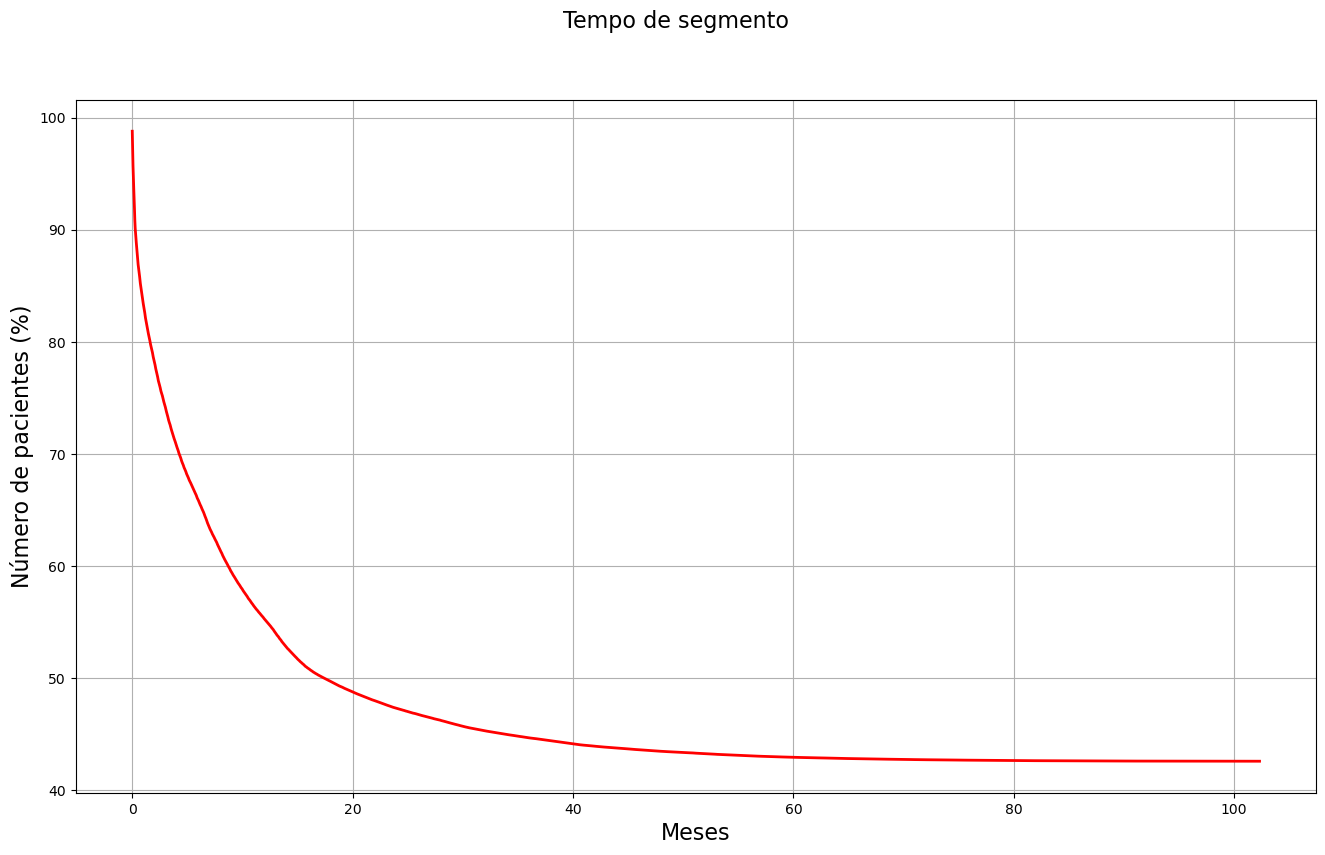

In [50]:
fig = plt.figure(figsize=[16, 9])
fig.suptitle('Tempo de segmento', fontsize=16)

# Plotando 2D

ax = fig.add_subplot(1, 1,1)

ax.set_ylabel('Número de pacientes (%)', fontsize=16)
ax.set_xlabel('Meses', fontsize=16)

ax.plot(unique_delta/30, percentage, 'r', linewidth=2)

ax.grid()

plt.show()

In [35]:
# salvando base de dados
formated_df.to_csv('tempo_de_segmento.csv', index=False,)  

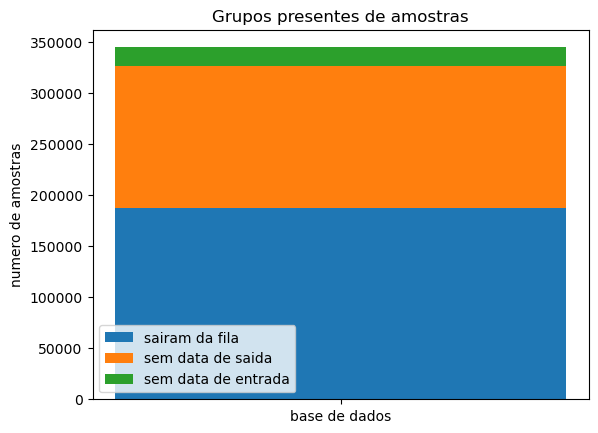

In [49]:
# importing package
import matplotlib.pyplot as plt
import numpy as np

# create data
x = ["base de dados"]
y1 = np.array([187253])
y2 = np.array([325667 - 187253])
y3 = np.array([344410 - 325667])

# plot bars in stack manner
plt.bar(x, y1)
plt.bar(x, y2, bottom=y1)
plt.bar(x, y3, bottom=y1 + y2)

plt.ylabel("numero de amostras")
plt.legend(["sairam da fila", "sem data de saida", "sem data de entrada"])
plt.title("Grupos presentes de amostras")
plt.show()